In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from pylab import rcParams
from mpl_toolkits.basemap import Basemap

%matplotlib inline
rcParams['figure.figsize'] = (10, 8)
from wordcloud import WordCloud

In [2]:
hillary_df = pd.read_csv('data/hillary_location.csv')
trump_df = pd.read_csv('data/trump_location.csv')

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
all_df = hillary_df.append(trump_df)

In [3]:
all_df = pd.read_csv('data/all.csv')

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
len(all_df)

1240276

In [5]:
all_df.drop_duplicates(subset='id', inplace=True)
len(all_df)

1222413

In [8]:
all_df.text.fillna('', inplace=True)

In [139]:
all_df.to_csv('data/all.csv', index=False)

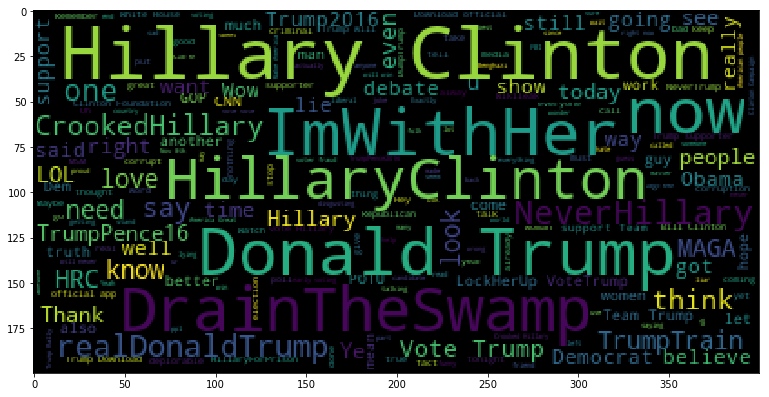

In [14]:
wordcloud = WordCloud().generate(' '.join(all_df.text) )
plt.figure(figsize=(13, 13))
plt.imshow(wordcloud)

In [5]:
def weighted_terms(vectorizer, tweets, num=100):
    '''display the top n most important words for this vectorizer with for the tweets
    vectorizer -- model to fit tweets, expecting instance of TfidfVectorizer
    tweets -- tweets going to transoform, expect pandas series format
    num -- how many top weighted words to show
    '''
    matrix = vectorizer.fit_transform(tweets)
    terms = vectorizer.get_feature_names()
    featres_weights = matrix.sum(axis=0)
    
    print('There are %d feature names.' % len(terms) )
    count = 0
    for index in np.argsort(-featres_weights).flat:
        count += 1
        if count > num:
            break

        print('%s %f' % (terms[index].ljust(25, ' '), featres_weights[0, index]) )

In [8]:
tfidf_vect = TfidfVectorizer(stop_words='english')

In [11]:
weighted_terms(tfidf_vect, all_df.text)

There are 139142 feature names.
trump                     27005.522195
imwithher                 22828.973483
vote                      20561.971338
hillary                   20113.388090
draintheswamp             19074.533118
neverhillary              14637.153699
realdonaldtrump           13158.617337
clinton                   12539.506840
hillaryclinton            10539.140319
just                      10288.026559
crookedhillary            9543.434491
maga                      8697.504474
america                   8403.450694
people                    8197.918167
don                       7916.137620
trumppence16              7856.320275
like                      7844.196876
trumptrain                7659.042418
time                      7237.959903
let                       6477.747580
president                 6289.293426
know                      6158.345944
voting                    6116.837997
make                      5881.545127
right                     5844.319630
election

We are planning to do clustering for this dataset, and interesting in how the above important key terms could help us to split. Here's some naive thoughts:

If we only cluster them into 2 groups, we should be get groups one mainly about trump's, and one mainly about clinton's.
If we cluster them into 3 groups, we migh get one group about trump, one for clinton and one neutral.
If we cluster them into 4 groups, we might get groups like pro and con trump, pro and con clinton.

Here are the words that might not be so helpful for the above purpose:

just, don (should be from don't, time, let, know, going, say, think, way, rt (re-tweet), said, new, does, day, got, says, doesn (from doesn't), ll (from I'll ?),  ve (from I've)

Note, I didn't include words like vote since they are expressing this person's will to vote or interested in election, and I am assuming there are neutral groups people who didn't interest in election at all but just tweet for fun and also words that have strong sentiment (like needs)

In [6]:
tweet_stop_words = text.ENGLISH_STOP_WORDS.union(['did', 'just', 'don', 'time', 'know', 'going', 'say', 'think', 'way', 'said', 'new', 'does', 'day', 'days', 'years', 'got', 'says', 'doesn', 'll', 've', 'twitter', 'pic', 'com', 'let', 'voting', 'rt', 'want', 'country', 'today', 'early', 'tonight', 'thing', 'didn', 'come', 'coming', 'tell', 'read'])

In [9]:
tfidf_vect = TfidfVectorizer(stop_words=tweet_stop_words)
weighted_terms(tfidf_vect, all_df.text)

There are 139105 feature names.
trump                     27640.629926
imwithher                 23068.302557
vote                      21406.724143
hillary                   20628.460665
draintheswamp             19218.047504
neverhillary              14764.379673
realdonaldtrump           13419.552805
clinton                   12768.711196
hillaryclinton            10786.935649
crookedhillary            9647.610391
maga                      8778.374988
america                   8662.832451
people                    8489.640567
like                      8120.753931
trumppence16              7936.602352
trumptrain                7752.797165
president                 6514.104428
make                      6087.831070
election                  6073.794206
right                     6066.160428
watch                     5920.034497
trump2016                 5856.807529
need                      5842.681079
donald                    5832.424959
love                      5758.456056
great    

In [141]:
def kmeans_weighted_terms(kmeans, matrix, feature_terms, num=25):
    '''display the top n most important words for this kmeans_model with for the given matrix and feature_terms
    Parameters:
    kmeans :  kmeans model to do clustering
    matrix : matrix you get after doing tfidf fit_transform
    feature_terms : list of featuer terms after you doing tfidf tif_transform
    num -- how many top weighted words to show
    '''

    print('Inertia (Cost / Lost) for this kmeans model : %f' % kmeans.inertia_ )
    print('%-50s | %s' % ('Centers (centroids):', 'Aggregate cluster weights:' ) )
    print()
    
    for cluster, row in enumerate(kmeans.cluster_centers_):
        print('%-50s | %s' %( 'Center %d'%(cluster), ('Aggregate %d'%(cluster)) ) )
        
        center_indexes = np.argsort(-row)
        current_feature_weights = matrix[kmeans.labels_ == cluster].sum(axis=0)
        aggregate_indexes = np.argsort(-current_feature_weights)
        
        for index in range(num):
            print('%-25s %24f | %-25s %24f' % (terms[center_indexes[index] ], row[center_indexes[index] ], terms[aggregate_indexes[0, index] ], current_feature_weights[0, aggregate_indexes[0, index]]) )
        print()

In [142]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(matrix)
kmeans_weighted_terms(kmeans, matrix, terms)

Inertia (Cost / Lost) for this kmeans model : 1179201.195434
Centers (centroids):                               | Aggregate cluster weights:

Center 0                                           | Aggregate 0
vote                                      0.283021 | vote                                  18620.313048
trump                                     0.158809 | trump                                 10448.066262
watch                                     0.029709 | watch                                  1954.531780
download                                  0.028134 | download                               1850.966558
app                                       0.027999 | app                                    1842.086568
official                                  0.027163 | official                               1787.062395
team                                      0.026732 | team                                   1758.668842
support                                   0.026207 | support     

In [143]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(matrix)
kmeans_weighted_terms(kmeans, matrix, terms)

Inertia (Cost / Lost) for this kmeans model : 1159936.250703
Centers (centroids):                               | Aggregate cluster weights:

Center 0                                           | Aggregate 0
trump                                     0.023068 | trump                                 27545.697573
imwithher                                 0.019314 | imwithher                             23063.230111
vote                                      0.017767 | vote                                  21215.558963
hillary                                   0.017240 | hillary                               20586.826391
realdonaldtrump                           0.011231 | realdonaldtrump                       13411.474766
clinton                                   0.010688 | clinton                               12762.511780
hillaryclinton                            0.009021 | hillaryclinton                        10772.207058
crookedhillary                            0.008076 | crookedhilla

In [144]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(matrix)
kmeans_weighted_terms(kmeans, matrix, terms)

Inertia (Cost / Lost) for this kmeans model : 1148787.235794
Centers (centroids):                               | Aggregate cluster weights:

Center 0                                           | Aggregate 0
hillary                                   0.017515 | hillary                               19460.848655
trump                                     0.015568 | trump                                 17296.871091
realdonaldtrump                           0.011721 | realdonaldtrump                       13023.472024
clinton                                   0.011098 | clinton                               12331.290842
hillaryclinton                            0.009363 | hillaryclinton                        10402.786891
crookedhillary                            0.008561 | crookedhillary                         9511.630170
maga                                      0.007711 | maga                                   8567.212339
like                                      0.007009 | like        

Let's try with LSA decomposition first then kmeans clustering:

In [146]:
svd = TruncatedSVD(100) # For LSA, a value of 100 is recommended.
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

In [147]:
X = lsa.fit_transform(matrix)

In [153]:
svd.explained_variance_.sum() * 100

21.744715679990779

In [158]:
def lsa_weighted_terms(kmeans, matrix, feature_terms, num=25):
    '''display the top n most important words for this kmeans_model with for the given matrix and feature_terms
    Parameters:
    kmeans :  kmeans model to do clustering
    matrix : matrix you get after doing tfidf fit_transform
    feature_terms : list of featuer terms after you doing tfidf tif_transform
    num -- how many top weighted words to show
    '''

    print('Inertia for this kmeans model after lsa: %f' % kmeans.inertia_ )
    print('Top terms per cluster:')
    print()
    
    for cluster in range(kmeans.n_clusters):
        print('Cluster %d' % cluster )
        current_feature_weights = matrix[kmeans.labels_ == cluster].sum(axis=0)
        aggregate_indexes = np.argsort(-current_feature_weights)
        for index in range(num):
            print('%-25s %24f' % (terms[aggregate_indexes[0, index] ], current_feature_weights[0, aggregate_indexes[0, index]]) )
        print()

In [160]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
lsa_weighted_terms(kmeans, matrix, terms)

Inertia for this kmeans model after lsa: 1092578.465682
Top terms per cluster:

Cluster 0
trump                                 27556.133345
imwithher                             23055.845120
vote                                  21360.833844
hillary                               20564.858372
draintheswamp                         19206.137207
neverhillary                          14753.324725
realdonaldtrump                       13307.520441
clinton                               12729.703927
hillaryclinton                        10771.397877
crookedhillary                         9639.074895
maga                                   8773.187640
america                                8629.736704
people                                 8388.538692
like                                   7932.910660
trumppence16                           7925.537053
trumptrain                             7747.899744
president                              6492.860396
make                                   6068

It seems like kmeans telling us trump and hillary support tweets more disguisable from those who are not so interested in election

In [161]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
lsa_weighted_terms(kmeans, matrix, terms)

Inertia for this kmeans model after lsa: 1059937.713787
Top terms per cluster:

Cluster 0
trump                                 27134.579069
imwithher                             19933.164102
donald                                 4347.926889
vote                                   3796.580766
watch                                  2096.691539
support                                2066.391708
team                                   1878.072442
download                               1852.426218
app                                    1848.211468
hillary                                1845.533649
official                               1833.273299
clinton                                1393.301360
rally                                  1017.561236
supporters                             1006.903703
make                                    990.495904
president                               975.473846
america                                 974.707399
win                                     880

In [162]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
lsa_weighted_terms(kmeans, matrix, terms)

Inertia for this kmeans model after lsa: 1028138.328432
Top terms per cluster:

Cluster 0
hillary                               20032.549424
clinton                                7020.882059
trump                                  1600.668508
crooked                                1464.460660
vote                                   1388.886294
realdonaldtrump                        1229.557634
fbi                                    1043.102130
president                               772.983306
investigation                           750.036195
promise                                 742.775084
obama                                   726.142988
campaign                                680.536053
america                                 627.972955
emails                                  619.016794
like                                    605.214866
reopened                                602.777186
people                                  590.222951
wikileaks                               568

Let's see some plot:

In [11]:
tfidf_vect = TfidfVectorizer(stop_words=tweet_stop_words)
matrix = tfidf_vect.fit_transform(all_df.text)

In [12]:
kmeans = MiniBatchKMeans(n_clusters=2) # faster kmeans algorithm
kmeans.fit(matrix)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=2,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [125]:
location = all_df[['lat', 'lon']]

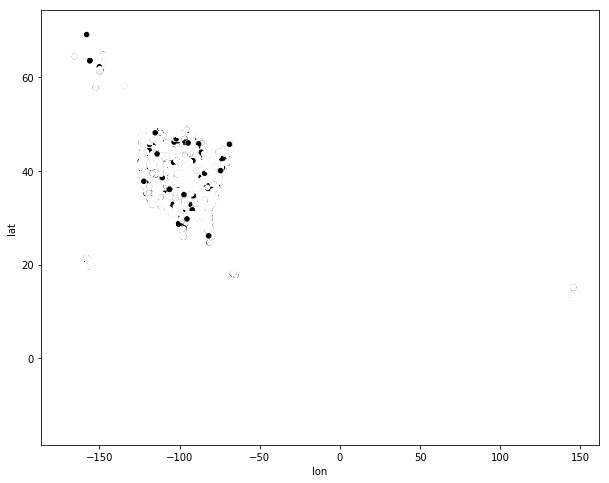

In [126]:
location.plot.scatter(x='lon', y='lat', c=kmeans.labels_)

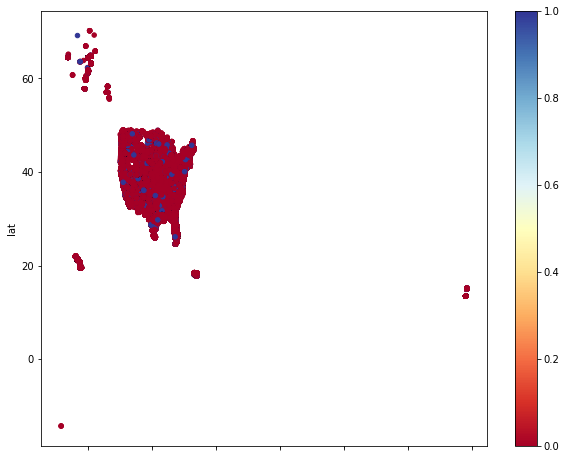

In [127]:
location.plot.scatter(x='lon', y='lat', c=kmeans.labels_, cmap='RdYlBu')

In [99]:
all_df.lon.min(), all_df.lon.max()

(-170.695974791655, 145.7174569)

In [106]:
all_df.lat.min(), all_df.lat.max()

(-14.30063095, 70.200697300000002)

In [93]:
lons = list(all_df.lon)
lats = list(all_df.lat)

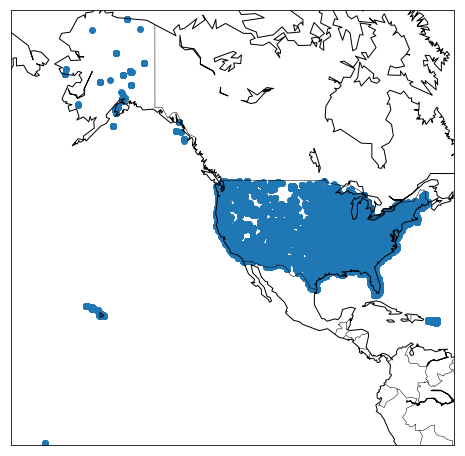

In [144]:
my_map = Basemap(projection='merc', resolution='c',
                llcrnrlat=-15, urcrnrlat=71,
                llcrnrlon=-180, urcrnrlon=-60)

x, y = my_map(lons, lats)
my_map.scatter(x, y)

my_map.drawcoastlines()
my_map.drawcountries()

In [117]:
guam = all_df[all_df.lon > -60]

In [118]:
guam.lat.min(), guam.lat.max(), guam.lon.min(), guam.lon.max()

(13.444138000000001, 15.207943499999999, 144.73362644576704, 145.7174569)

There are some outliers for location. After searching, I think that's mainly for a place called Guam, which having longitudes > -6

In [119]:
guam_lons, guam_lats = list(guam.lon), list(guam.lat)

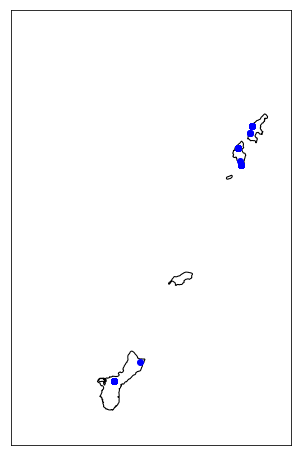

In [123]:
# need a higher resolution in order to display for small 
my_map = Basemap(projection='merc', resolution='h',
                llcrnrlat=13, urcrnrlat=16,
                llcrnrlon=144, urcrnrlon=146)


guam_x, guam_y = my_map(guam_lons, guam_lats)
my_map.plot(guam_x, guam_y, 'bo')

my_map.drawcoastlines()
my_map.drawcountries()

In [152]:
def kmeans_plot_map(kmeans, lat_lon_df):
    '''plot sctter plots for different clustering base on kmeans
    kmeans : kmeans model, should be already fit
    lat_lon_df : a pandas dataframe containing latitudes and longitudes'''
    
    my_map = Basemap(projection='merc', resolution='c',
                llcrnrlat=-15, urcrnrlat=71,
                llcrnrlon=-180, urcrnrlon=-60)
    
    lons, lats = lat_lon_df.lon.values, lat_lon_df.lat.values
    for k in range(kmeans.n_clusters):
        current_lons = lons[ kmeans.labels_ == k ]
        current_lats = lats[ kmeans.labels_ == k ]
        x, y = my_map(current_lons, current_lats)
        my_map.scatter(x, y)
        
    my_map.drawcoastlines()
    my_map.drawcountries()

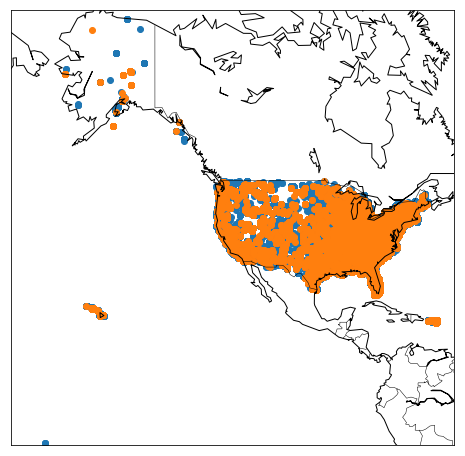

In [153]:
kmeans_plot_map(kmeans, all_df)